<center>

#  Datamining for Big Data 
##  Recommendation System  with Graph Mining 
</center> 


### 0- Mounting Drive ...

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### 1- Loading Library, Dataset and Utilities functions ... 

In [2]:
# Installing dependencies ....
! pip install textblob

# Loading dependencies  ....
import networkx as nx 
from networkx.algorithms.distance_measures import diameter
from networkx.algorithms.community import community_utils
from networkx.algorithms.community import greedy_modularity_communities

from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.centrality import edge_betweenness_centrality
from networkx.algorithms.community.centrality import girvan_newman
import pandas as pd
import numpy as np
import statistics as stats
import community
import collections
import math
from matplotlib  import pyplot as plt 
from textblob import TextBlob
import re
import random 
import json

In [0]:
# Initializing gloabal variables ...
_root = "/content/drive/My Drive/SOCIAL_MINING"
_url_src_dataset = _root+"/data/export_articles_EGC_2004_2018.csv"
_url_similarity_score = _root+"/data/similarityscore.csv"

In [0]:
# Implementing Utilities Functions ...
def get_node_properties(node_id, df):
  """
    Method used to get details/properties of a node given a node number 
  
    @params: 
      node_id[Integer]: Node number / ID 
      df[Pandas.Dataframe]: Source DataFrame 
    @Returns:
      Dictionaries of all details about the Node 
  """
  assert( node_id  in range(df.shape[0]) )
  return dict(df.iloc[node_id])

def is_positive_integer(i):
  try:
    i = int(i)
    if i >=0:
      return True
  except Exception as e:
    pass
  return False 

def split_string_in_chunks(x, chunk_size  ):
  chunks = len(x)
  return [ x[i:i+chunk_size] for i in range(0, chunks, chunk_size) ]

def _remove_all_special_chars(input_text):
  assert (type(input_text) == str)

  output_text = [re.sub(r"[^a-zA-Z]+", ' ', k) for k in input_text.split("\n")]
  output_text = " ".join(output_text).replace("\n", " ")
  output_text = output_text.lower()
  return output_text

def _reverse_key_value(my_dict):
  tmp = dict()
  for (k,v) in my_dict.items() :
    if v not in tmp:
      tmp[v] = list() 
    tmp[v].append(k)

  return tmp 


In [0]:
# Loading Dataset ...
src_df = pd.read_csv(_url_src_dataset,delimiter="\t")
sim_df = pd.read_csv(_url_similarity_score,delimiter=",")
sim_df = sim_df.drop('Unnamed: 0', 1)

### 2- Data Visualization  ... 

In [6]:
print("src_df.shape: ", src_df.shape)
print(src_df.columns)
print(sim_df.columns)
src_df.head(5)

src_df.shape:  (1269, 8)
Index(['series', 'booktitle', 'year', 'title', 'abstract', 'authors',
       'pdf1page', 'pdfarticle'],
      dtype='object')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1259', '1260', '1261', '1262', '1263', '1264', '1265', '1266', '1267',
       '1268'],
      dtype='object', length=1269)


,series,booktitle,year,title,abstract,authors,pdf1page,pdfarticle
0,Revue des Nouvelles Technologies de l'Information,EGC,2018,#Idéo2017 : une plateforme citoyenne dédiée à ...,Cette plateforme a pour objectif de permettre ...,"Claudia Marinica, Julien Longhi, Nader Hassine...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002425
1,Revue des Nouvelles Technologies de l'Information,EGC,2018,A two level co-clustering algorithm for very l...,La classification croisée (co-clustering) est ...,"Marius Barctus, Marc Boullé, Fabrice Clérot",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002372
2,Revue des Nouvelles Technologies de l'Information,EGC,2018,ALGeoSPF: Un modèle de factorisation basé sur ...,La recommandation de points d'intérêts est dev...,"Jean-Benoît Griesner, Talel Abdesssalem, Huber...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002380
3,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse des sentiments à partir des commentair...,L'analyse des sentiments est un processus pend...,"Abdeljalil Elouardighi, Mohcine Maghfour, Hafd...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002397
4,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse en rôles sémantiques pour le résumé au...,Cet article présente une approche visant à ext...,"Elyase Lassouli, Yasmine Mesbahi, Camille Prad...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002384


In [7]:
#src_df.loc[1145]
src_df.loc[4]

series        Revue des Nouvelles Technologies de l'Information
booktitle                                                   EGC
year                                                       2018
title         Analyse en rôles sémantiques pour le résumé au...
abstract      Cet article présente une approche visant à ext...
authors       Elyase Lassouli, Yasmine Mesbahi, Camille Prad...
pdf1page      http://editions-rnti.fr/render_pdf.php?p1&p=10...
pdfarticle     http://editions-rnti.fr/render_pdf.php?p=1002384
Name: 4, dtype: object

### 3- Data Preprocessing ...

In [8]:
# Creating Trivial Distance Function base on disctance function derived from mxm matrix ...
m,n = src_df.shape 
#m= 1000
#dist_matrix = np.random.randint(0,1000, size=(m,m) ) 
dist_matrix = sim_df.values
print("dist_matrix: \n", dist_matrix)

dist_matrix: 
 [[1.         0.03175874 0.03774489 ... 0.         0.0163006  0.0202879 ]
 [0.03175874 1.         0.12842015 ... 0.00364649 0.01581375 0.14576674]
 [0.03774489 0.12842015 1.         ... 0.         0.02892527 0.06165638]
 ...
 [0.         0.00364649 0.         ... 1.         0.         0.        ]
 [0.0163006  0.01581375 0.02892527 ... 0.         1.         0.00410653]
 [0.0202879  0.14576674 0.06165638 ... 0.         0.00410653 1.        ]]


In [9]:
# Filtering the distance function using the defined threashold ... 
#_threashold = 0.04
#_threashold = 0.07
_threashold = 0.03
for i in range(m):
  dist_matrix[:,i] = [ 0 if x<_threashold  else x for x in dist_matrix[:,i]   ]
print("dist_matrix: \n", dist_matrix)

dist_matrix: 
 [[1.         0.03175874 0.03774489 ... 0.         0.         0.        ]
 [0.03175874 1.         0.12842015 ... 0.         0.         0.14576674]
 [0.03774489 0.12842015 1.         ... 0.         0.         0.06165638]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.14576674 0.06165638 ... 0.         0.         1.        ]]


In [10]:
# Defining Nodes using source dataframe ...
G = nx.Graph()
for n in range(m):
  # Adding the properties each node ... 
  G.add_node(n, **get_node_properties(n, src_df))

print("Node Title Properties: ",G.nodes[0]["title"])

# Defining Edegs based on the distance/weight matric  ...
for i in range(m):
  for j in range(m):
    if dist_matrix[i,j] != 0 and i != j  :
      G.add_edge(i,j,weight=dist_matrix[i,j] ) 

#print("Edge weight : ",G.edges[0, 1]['weight'])

Node Title Properties:  #Idéo2017 : une plateforme citoyenne dédiée à l'analyse des tweets lors des événements politiques


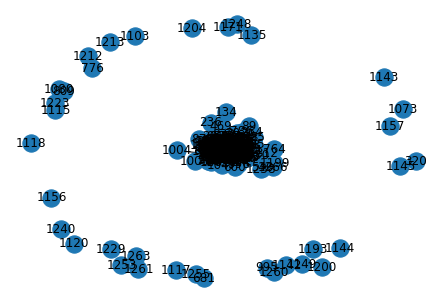

<Figure size 1224x216 with 0 Axes>

In [0]:
# Plotting graph ...
G.add_nodes_from(list(range(m) ))
nx.draw(G, with_labels=True)
plt.figure(figsize=(17,3))
plt.show()



### 4- Network  Analysis ... 

In [11]:
# Global Network Analysis ...
n_edges = G.number_of_edges()
n_nodes = G.number_of_nodes()
#g_diameter = nx.diameter(G)
g_degree = nx.degree(G)
g_max_degree = max( [ x[1] for x in  g_degree ] )
g_min_degree = min( [ x[1] for x in  g_degree ] )
g_avg_degree = math.ceil(stats.mean( [ x[1] for x in  g_degree ] ))
g_density = round(nx.density(G),2)

print("Number of Edges", n_edges )
print("Number of Node", n_nodes)
#print("Graph Diameter", g_diameter)
print("Graph Max Degree ",g_max_degree  )
print("Graph Min Degree ",g_min_degree  )
print("Graph Mean Degree ",g_avg_degree  )
print("Graph Density ", g_density)

# Local Network Analysis ... 



Number of Edges 490158
Number of Node 1269
Graph Max Degree  1194
Graph Min Degree  0
Graph Mean Degree  773
Graph Density  0.61


### 5- Recommendation System Implementation ...

In [0]:
# Selecting matching candidates per the book(s) read ... 
def detect_communities(G):
  community_ = node_candidates_girvan_newman(G)
  return community_ , _reverse_key_value( community_),community.modularity(community_, G )


def node_candidates_girvan_newman(G):
  community_ = community.best_partition(G,weight='weight', random_state= 1)
  return community_

def node_candidates_greedy(G):
  greedy_com=list(greedy_modularity_communities(G, weight="weight"))
  return greedy_com

def node_candidates_clique(G, n_cliques = 3):
  clique_com = list(k_clique_communities(G, n_cliques))
  return clique_com

def node_candidates(community,list_read, nb_candidates = 10):
  rv_community = _reverse_key_value( community)
  tmp = list()
  for one_read in list_read :
    tmp.append(community[one_read])

  nb_elem = len(tmp)
  counter=collections.Counter(tmp)
  freq_tmp =  dict(counter)
  result = list()
  for k,v in freq_tmp.items():
    nb_items = int((v/nb_elem) * nb_candidates)
    l2 = random.sample(rv_community[k], k=nb_items)
    result = [*result, *l2]
  return result 

# Ranking candidates ( google index based ranking No dead end trap and )...
def ranking_candidate(G, list_read, list_candidate ):
  assert(type(list_candidate)  == list)
  assert(type(list_read) == list )

  # remove  list_read from candidate 
  list_candidate =  [x for x in list_candidate if x not in list_read]
  # Plot the subgrah of the articles read + candidates 
  combined = list_read + list_candidate
  print(combined)
  H = G.subgraph(combined)
  print(H)
  nx.draw(H, with_labels=True)
  plt.figure(figsize=(17,3))
  plt.show()
  # Ranking based on proximity measure
  #print(G.number_of_edges(1,7))
  # Compute edge betweeness centrality in the Subgraph 
  all_edge_betweeness = edge_betweenness_centrality(H,weight="weight") 
  #print(edge_betweenness_centrality(H,weight="weight") )
  # Compute weighted  betweeness score for each candidates (nodes )  ...
  for edge in all_edge_betweeness:
    score = all_edge_betweeness[edge]
    H.nodes[edge[0]]["betweeness_score"] = (0 if  "betweeness_score" not in  H.nodes[edge[0]] else H.nodes[edge[0]]["betweeness_score"]) +  score
    H.nodes[edge[1]]["betweeness_score"] = (0 if  "betweeness_score" not in  H.nodes[edge[1]] else H.nodes[edge[1]]["betweeness_score"]) +  score
  
  result = dict()
  for candidate in list_candidate :
    if "betweeness_score" in  H.nodes[candidate]:
      result[candidate] = round( H.nodes[candidate]["betweeness_score"],3)
    else:
      result[candidate] = 0
  
  # Sort candidate in Descending order according to w
  sorted_result = {k: v for k, v in sorted(result.items(), key=lambda item: item[1],reverse=True )}
  return list(sorted_result.keys()), sorted_result

#all_communities,_,_ = detect_communities(G)
#node_candidates(all_communities,[4,5,6,7,8,9,1,2], nb_candidates = 100)

modularity_score 0.12828382669842328
{"0": [0, 4, 5, 12, 16, 17, 18, 19, 25, 28, 31, 35, 36, 38, 43, 44, 45, 46, 49, 53, 55, 56, 57, 60, 61, 62, 63, 65, 67, 68, 69, 73, 76, 78, 86, 89, 93, 95, 96, 98, 100, 101, 103, 104, 106, 109, 110, 111, 114, 120, 121, 125, 132, 137, 138, 140, 142, 143, 144, 147, 148, 152, 158, 166, 169, 171, 172, 174, 179, 180, 181, 182, 188, 192, 194, 196, 197, 204, 210, 211, 215, 217, 219, 220, 222, 225, 226, 228, 229, 230, 231, 233, 237, 240, 242, 248, 249, 250, 252, 254, 257, 258, 259, 260, 261, 262, 263, 264, 266, 269, 278, 279, 286, 287, 289, 290, 295, 296, 297, 301, 302, 312, 315, 318, 319, 320, 324, 326, 327, 335, 340, 343, 344, 354, 356, 357, 365, 366, 370, 372, 374, 377, 383, 384, 387, 388, 395, 398, 401, 405, 408, 412, 413, 415, 417, 418, 419, 423, 425, 427, 429, 431, 433, 437, 439, 440, 459, 460, 465, 466, 474, 477, 478, 481, 482, 485, 486, 495, 496, 501, 502, 503, 504, 509, 514, 515, 518, 524, 526, 527, 530, 532, 540, 550, 551, 552, 555, 556, 558, 559,

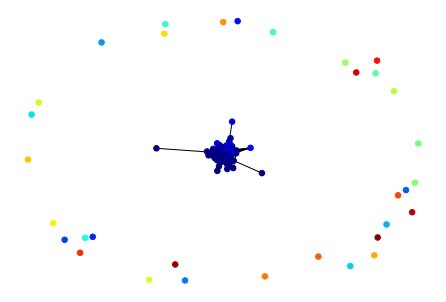

In [13]:
# Testing edge betweeness based community detection ...
all_communities  = node_candidates_girvan_newman(G)
all_communities_as_clusters = _reverse_key_value( all_communities)
print("modularity_score", community.modularity(all_communities, G ))
print(json.dumps(all_communities_as_clusters)  )

values = [all_communities.get(node) for node in G.nodes()]
nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)

In [0]:
# Testing Greedy community detection ...
greedy_c = node_candidates_greedy(G, )
sorted(sorted(greedy_c) )

In [0]:
# Testing Clique community detection (Strong Assumption) ...
clique_c = node_candidates_clique(G)
clique_c

In [0]:
# Testing ranking candidate ... 
v,p = ranking_candidate(G, [5], [2,3,6,7])
print(v,p)

[7, 2, 3, 6] {7: 15.4, 2: 4.4, 3: 4.4, 6: 4.4}


In [0]:
from networkx import edge_betweenness_centrality as betweenness
def most_central_edge(G):
    centrality = betweenness(G, weight='weight')
    return max(centrality, key=centrality.get)


comp = girvan_newman(G, most_valuable_edge=most_central_edge)
tuple(sorted(c) for c in next(comp))


### 6- System Evaluation ...

### 7 - Demo (console)

In [0]:
all_communities,_,_ = detect_communities(G)


What book have you read : 34


You have read book id 34: [ Fouille de motifs temporels négatifs ]

Recommendation 
---------------
[34, 8, 9, 1, 2, 915, 234, 310, 1233, 567, 711, 713, 691, 23, 971, 464, 523, 560, 1002, 1150, 676, 1163, 1091, 730, 653, 490, 432, 309, 85, 385, 361, 939, 807, 679, 1172, 1075, 1017, 79, 83, 456, 1042, 1226, 183, 153, 443, 986, 323, 161, 469, 900, 236, 844, 689, 1220, 483, 52, 195, 975, 82, 840, 445, 244, 81, 473, 118, 1257, 859, 770, 535, 176, 307, 22, 876, 238, 337, 909, 907, 1190, 811, 548, 255, 800, 547, 123, 371, 1268, 789, 819, 656, 1195, 470, 281, 313, 534, 449, 1025, 709, 167, 910, 392, 146, 572, 347, 135]



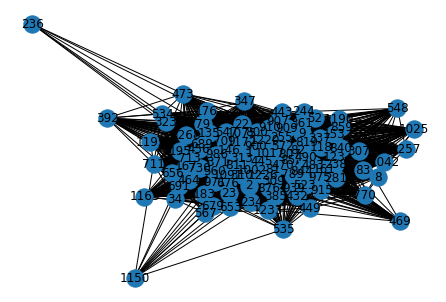

<Figure size 1224x216 with 0 Axes>

,Id,Score,Title
0,1163,0.077,Raisonnement en gestion des compétences
1,392,0.066,Comprendre et interpréter les données : enjeux et implantations d'un système de codage dans des gisements de données historiques
2,1195,0.062,Apprentissage et optimisation conjoints : extraction de connaissances pertinentes sur les systèmes de production
3,534,0.062,Early Classification on Temporal Sequences
4,323,0.06,Détection de situations à risque basée sur des détecteurs de mouvement à domicile pour les personnes dépendantes
...,...,...,...
94,1220,0.019,Fouille de grands ensembles de données avec un boosting proximal SVM
95,82,0.019,Classification d'objets 3D par extraction aléatoire de sous-parties discriminantes pour l'étude du sous-sol en prospection pétrolière
96,789,0.019,Un critère d'évaluation Bayésienne pour la construction d'arbres de décision
97,313,0.019,Comparaison de bornes théoriques pour l'accélération du clustering incrémental en une passe


In [15]:
book_read_id = None 
n_nodes = G.number_of_nodes()
while True:
  book_read_id = input("What book have you read : ")
  if is_positive_integer(book_read_id) is True: 
    if int(book_read_id)  in range(n_nodes) :
      break
    else:
       print("Invalid Input. book_id selected does not exists ")
  else:
    print("Invalid Input. Positive Number Expected ")


# Recommendation ...
node_selected = int(book_read_id)
print("\n\nYou have read book id {}: [ {} ]".format(book_read_id,G.nodes[node_selected]["title"]) )
print("\nRecommendation ")
print("---------------")
list_read = [node_selected,8,9,1,2]
lst_neighbors = node_candidates(all_communities,list_read, nb_candidates = 100)
sorted_node , ranking_index = ranking_candidate(G, list_read, lst_neighbors)


result_df = pd.DataFrame(columns=["Id","Score","Title"])
i = 0 
for n in sorted_node:
  result_df.loc[i, "Id"] = n
  result_df.loc[i, "Score"] = ranking_index[n]
  result_df.loc[i, "Title"] = str(G.nodes[n]["title"]).strip()
  #print("id: ",n," | ", ranking_index[n], "| Title:",G.nodes[n]["title"])
  i+=1

pd.set_option("display.max_colwidth",800)
result_df

# Be careful with with stop word elimination since there are some docs in english and french 
#30  |  0.22 | Title: Exploration et analyses multi-objectifs de séries temporelles de données météorologiques
#14  |  0.02 | Title: Community structure in complex networks
 

For Live demo (Graphical User Interface) [link text](https://)

### 8 -  Intermission 

#### 8-1 Scraping & Translating Documents

In [0]:
! pip install langdetect
! pip install py-translate
! pip install googletrans
! pip install textract
! pip install tika 

from langdetect import detect
from googletrans import Translator
import textract
import urllib.request
import time
from tika import parser

     |████████████████████████████████| 1.0MB 4.9MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993460 sha256=18dc9c4013f094fb8953a32f4a33d01502eaf33e022cdf878afd5ed4a1fa7277
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15776 sha256=d4881465d0bb2f9c7989c5b6d8545f8df5271ca3ccd1d1991255258f5c0bf957
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans
     |████████████████████████████████| 5.6MB 6.8MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 32.8MB 117kB/s 
     |████████████████████████████████| 112kB 50.4MB/s 
     |████████████

In [0]:
# Retrieving title Columns from  src_df  
article_title = src_df["title"].values 
language_col  = list()

# Browising trough  every title and evaluating their respective languages ...
for i in range( article_title.shape[0] ):
  lang = detect(article_title[i])
  language_col.append("fr" if lang != "fr" and lang != "en" else lang)

# Adding new column  [lang] to new Dataframe [src_scrap_df]  ... 
src_scrap_df = pd.DataFrame(src_df)
src_scrap_df["lang"] = language_col

# Saving new datafracme to output file ... 
#src_scrap_df.to_csv(_root+"/out/articles_plus_lang.csv")

# Visualising Dataframe ....
src_scrap_df.head(100)


,series,booktitle,year,title,abstract,authors,pdf1page,pdfarticle,lang
0,Revue des Nouvelles Technologies de l'Information,EGC,2018,#Idéo2017 : une plateforme citoyenne dédiée à ...,Cette plateforme a pour objectif de permettre ...,"Claudia Marinica, Julien Longhi, Nader Hassine...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002425,fr
1,Revue des Nouvelles Technologies de l'Information,EGC,2018,A two level co-clustering algorithm for very l...,La classification croisée (co-clustering) est ...,"Marius Barctus, Marc Boullé, Fabrice Clérot",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002372,en
2,Revue des Nouvelles Technologies de l'Information,EGC,2018,ALGeoSPF: Un modèle de factorisation basé sur ...,La recommandation de points d'intérêts est dev...,"Jean-Benoît Griesner, Talel Abdesssalem, Huber...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002380,fr
3,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse des sentiments à partir des commentair...,L'analyse des sentiments est un processus pend...,"Abdeljalil Elouardighi, Mohcine Maghfour, Hafd...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002397,fr
4,Revue des Nouvelles Technologies de l'Information,EGC,2018,Analyse en rôles sémantiques pour le résumé au...,Cet article présente une approche visant à ext...,"Elyase Lassouli, Yasmine Mesbahi, Camille Prad...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002384,fr
...,...,...,...,...,...,...,...,...,...
95,Revue des Nouvelles Technologies de l'Information,EGC,2017,Expression des connaissances en langage nature...,NaN,"Jérémy Vizzini, Cyril Labbé, François Portet",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002319,fr
96,Revue des Nouvelles Technologies de l'Information,EGC,2017,Extraction automatique de paysages en imagerie...,Nous présentons ici une méthode originale pour...,"Anne Toulet, Emmanuel Roux, Anne-Elisabeth Laq...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002285,fr
97,Revue des Nouvelles Technologies de l'Information,EGC,2017,Extraction de chroniques discriminantes,L'extraction de motifs séquentiels vise à extr...,"Yann Dauxais, David Gross-Amblard, Thomas Guye...",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002278,fr
98,Revue des Nouvelles Technologies de l'Information,EGC,2017,Extraction de relations pour le peuplement d'u...,"Dans une base de connaissance, les entités se ...","Cédric Lopez, Elena Cabrio, Frédérique Segond",http://editions-rnti.fr/render_pdf.php?p1&p=10...,http://editions-rnti.fr/render_pdf.php?p=1002301,fr


In [0]:
# Counting the number of Document written in english 
english_articles_df = src_scrap_df[src_scrap_df['lang'] == "en"]
print("Number of documents detected in English: {} ".format( str(len(english_articles_df))))

urls_articles_full = english_articles_df["pdfarticle"].values 
ids  = english_articles_df.index.values


# Downloading content of English Articles and save it locally...
i = 0 
for url in urls_articles_full: 
  if ids[i] < 967:
    continue 
  filename = _root+"/data/articles/pdf_{}.pdf".format(str(ids[i]))
  urllib.request.urlretrieve(url, filename) 
  time.sleep(2)
  i += 1


Number of documents detected in English: 123 


In [0]:

# Translating English articles into French using selenium/GoogleTrans ...
max_char_google_trans = 4000
docs_content = content_part4

while True:
  for cur_id in ids: 
    
    if cur_id  in docs_content.keys():
      continue
    filename = _root+"/data/articles/pdf_{}.pdf".format(str(cur_id))
    # Extracting content from pdf ...

    """
    text = textract.process(filename, method="tesseract", encoding = "latin", language='en')
    #print("Lenght of Text ",len(text))
    """
    
    
    # Parse data from file
    text = parser.from_file(filename)
    # Get files text content
    text = text['content']

    #print(text[0:300])

    # Spliting content into chuncks using [max_char_google_trans]
    text_parts  = split_string_in_chunks(text,max_char_google_trans)
    print("Number of chuncks ",len(text_parts))

    
    # Translate each chunk 
    tmp = list()
    is_break = False
    try:
      for chunk  in text_parts:
        translator = Translator()
        chunk  =chunk.strip()
        chunk = chunk.replace("\n", " ")
        st = random.randint(2, 4)
        time.sleep(st)
        tmp.append( str(translator.translate(chunk[0:1000], src="en", dest="fr").text) )
    except Exception as e :
        is_break = True 
        print(e)
        pass
    if is_break is False:
      translated_text = " ".join(tmp)
      docs_content[cur_id] = translated_text

  if len(docs_content)  == len(ids) :
    break
  

#print(docs_content)


#src_scrap_df["content_translated"] = list(docs_content.values())

Number of chuncks  9
Number of chuncks  2
Number of chuncks  2
Number of chuncks  1
Number of chuncks  7


* Next week wednesday for class 26th on Social mining 
* GoogleTrans https://pypi.org/project/googletrans/  \[ 15k max string \]
* Textract http://textract.readthedocs.io/en/latest/
* http://ryancompton.net/2014/06/16/community-detection-and-colored-plotting-in-networkx/


In [0]:
docs_content =content_part3
len(docs_content)

123

In [0]:
content_part4 = dict(docs_content)
len(content_part4)

118

In [0]:
content_part5 = dict(docs_content)
len(content_part5)

123

In [0]:
english_articles_df["content_translated"] = list(docs_content.values())
english_articles_df.to_csv(_root+"/out/english_articles_translated.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
docs_content_saved = dict(docs_content)

### 9- Deploying as a class 

In [0]:
####################
#   DEPENDENCIES   #
####################
import networkx as nx 
from networkx.algorithms.distance_measures import diameter
from networkx.algorithms.community import community_utils
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.centrality import edge_betweenness_centrality
from networkx.algorithms.community.centrality import girvan_newman
import pandas as pd
import numpy as np
import statistics as stats
import community
import collections
import os.path

import math
from matplotlib  import pyplot as plt 
from textblob import TextBlob
import re
import random 
import json

_root = "/content/drive/My Drive/SOCIAL_MINING"
_url_src_dataset = _root+"/data/export_articles_EGC_2004_2018.csv"
_url_similarity_score = _root+"/data/similarityscore.csv"

class SocialMining :
###############################################################################
#                         SOCIAL MINING CLASS   
###############################################################################
  def __init__(self, _url_src_dataset, _url_similarity_score, _threashold = 0.07 ):
    if os.path.exists(_url_src_dataset) is False:
      raise Exception("File [{}] does not exit ".format(_url_src_dataset))
    if os.path.exists(_url_similarity_score) is False:
      raise Exception("File [{}] does not exit ".format(_url_similarity_score))
    assert( type(_threashold) == float  and _threashold >= 0 )

    self.url_src_dataset = _url_src_dataset 
    self.url_similarity_score = _url_similarity_score
    self.threashold = _threashold
    self.src_df = None
    self.sim_df = None
    self.G = None 
    self.dist_matrix = None
    self.n_nodes = 0 
    self.n_edges = 0
    self.communities = None
    
    if self._load_data() is False:
        raise Exception("Error occured while loading data ")

    if self._build_graph() is False:
        raise Exception("Error occured while Building graph ")
    
  

  ####################
  #     PUBLIC       #
  ####################

  def describe_graph(self):
    # Global Network Analysis ...
    n_edges = self.G.number_of_edges()
    n_nodes = self.G.number_of_nodes()
    g_degree = nx.degree(self.G)
    g_max_degree = max( [ x[1] for x in  g_degree ] )
    g_min_degree = min( [ x[1] for x in  g_degree ] )
    g_avg_degree = math.ceil(stats.mean( [ x[1] for x in  g_degree ] ))
    g_density = round(nx.density(self.G),2)
    # printing metrics ...
    print("Number of Edges", n_edges )
    print("Number of Node", n_nodes)
    print("Graph Max Degree ",g_max_degree  )
    print("Graph Min Degree ",g_min_degree  )
    print("Graph Mean Degree ",g_avg_degree  )
    print("Graph Density ", g_density)


  def detect_communities(self):
    self.communities = self._node_candidates_girvan_newman()
    return self.communities , SocialMining._reverse_key_value( self.communities),community.modularity(self.communities, self.G )


  def recommend_articles(self, article_already_read, nb_recommendations = 10, plot_subgraph = True):
    if  self.communities is None:
      self.detect_communities()
    
    list_candidate = self._node_candidates(article_already_read, nb_candidates = nb_recommendations)
    list_candidate_ranked = self._ranking_candidate(article_already_read, list_candidate, plot_subgraph = plot_subgraph )
    return list_candidate_ranked

  def set_threashold(self,_threashold):
    assert( type(_threashold) == float )
    self.threashold = _threashold
    # Rebuilding  Graph ... 
    return self._build_graph()

  def get_graph(self):
    return self.G

  ####################
  #    PRIVATE       #
  ####################

  def _load_data(self):
    try:
      self.src_df = pd.read_csv(self.url_src_dataset,delimiter="\t")
      self.sim_df = pd.read_csv(self.url_similarity_score,delimiter=",")
      self.sim_df = self.sim_df.drop('Unnamed: 0', 1)
      return True
    except Exception as e:
      print(e)
      return False
  
  def _build_graph(self):
    try:
      m,n = self.src_df.shape 
      self.dist_matrix = self.sim_df.values
      for i in range(m):
        self.dist_matrix[:,i] = [ 0 if x<self.threashold  else x for x in self.dist_matrix[:,i]   ]
      
      self.G = nx.Graph()
      for n in range(m):
        # Adding the properties each node ... 
        self.G.add_node(n, **SocialMining.get_node_properties(n, self.src_df))

      #print("Node Title Properties: ",self.G.nodes[0]["title"])

      # Defining Edegs based on the distance/weight matric  ...
      for i in range(m):
        for j in range(m):
          if self.dist_matrix[i,j] != 0 and i != j  :
            self.G.add_edge(i,j,weight= self.dist_matrix[i,j] ) 
      
      self.n_edges = self.G.number_of_edges()
      self.n_nodes = self.G.number_of_nodes()

      return True
    except Exception as e:
      print(e)
      return False
  

  # Selecting matching candidates per the book(s) read ... 

  def _node_candidates_girvan_newman(self):
    community_ = community.best_partition(self.G,weight='weight', random_state= 1)
    return community_

  def _node_candidates_greedy(self):
    greedy_com=list(greedy_modularity_communities(self.G, weight="weight"))
    return greedy_com

  def _node_candidates_clique(self, n_cliques = 3):
    clique_com = list(k_clique_communities(self.G, n_cliques))
    return clique_com

  def _node_candidates(self,list_read, nb_candidates = 10):
    rv_community = SocialMining._reverse_key_value( self.communities)
    tmp = list()
    for one_read in list_read :
      tmp.append(self.communities[one_read])

    nb_elem = len(tmp)
    counter=collections.Counter(tmp)
    freq_tmp =  dict(counter)
    result = list()
    for k,v in freq_tmp.items():
      nb_items = int((v/nb_elem) * nb_candidates)
      l2 = random.sample(rv_community[k], k=nb_items)
      result = [*result, *l2]
    return result 

  # Ranking candidates ( google index based ranking No dead end trap and )...
  def _ranking_candidate(self, list_read, list_candidate, plot_subgraph = True ):
    assert(type(list_candidate)  == list)
    assert(type(list_read) == list )

    # remove  list_read from candidate 
    list_candidate =  [x for x in list_candidate if x not in list_read]
    # Plot the subgrah of the articles read + candidates 
    combined = list_read + list_candidate
    H = self.G.subgraph(combined)
    if plot_subgraph is True :
      nx.draw(H, with_labels=True)
      plt.figure(figsize=(17,3))
      plt.show()
    # Ranking based on proximity measure
    # Compute edge betweeness centrality in the Subgraph 
    all_edge_betweeness = edge_betweenness_centrality(H,weight="weight") 
    # Compute weighted  betweeness score for each candidates (nodes )  ...
    for edge in all_edge_betweeness:
      score = all_edge_betweeness[edge]
      H.nodes[edge[0]]["betweeness_score"] = (0 if  "betweeness_score" not in  H.nodes[edge[0]] else H.nodes[edge[0]]["betweeness_score"]) +  score
      H.nodes[edge[1]]["betweeness_score"] = (0 if  "betweeness_score" not in  H.nodes[edge[1]] else H.nodes[edge[1]]["betweeness_score"]) +  score
    
    result = dict()
    for candidate in list_candidate :
      if "betweeness_score" in  H.nodes[candidate]:
        result[candidate] = round( H.nodes[candidate]["betweeness_score"],3)
      else:
        result[candidate] = 0

    # Sort candidate in Descending order according to w
    sorted_result = {k: v for k, v in sorted(result.items(), key=lambda item: item[1],reverse=True )}
    return list(sorted_result.keys()), sorted_result


  ####################
  #   AXILIARIES     #
  ####################
    # Implementing Utilities Functions ...
  def get_node_properties(node_id, df):
    """
      Method used to get details/properties of a node given a node number 
    
      @params: 
        node_id[Integer]: Node number / ID 
        df[Pandas.Dataframe]: Source DataFrame 
      @Returns:
        Dictionaries of all details about the Node 
    """
    assert( node_id  in range(df.shape[0]) )
    return dict(df.iloc[node_id])

  def is_positive_integer(i):
    try:
      i = int(i)
      if i >=0:
        return True
    except Exception as e:
      pass
    return False 

  def split_string_in_chunks(x, chunk_size  ):
    chunks = len(x)
    return [ x[i:i+chunk_size] for i in range(0, chunks, chunk_size) ]

  def _remove_all_special_chars(input_text):
    assert (type(input_text) == str)

    output_text = [re.sub(r"[^a-zA-Z]+", ' ', k) for k in input_text.split("\n")]
    output_text = " ".join(output_text).replace("\n", " ")
    output_text = output_text.lower()
    return output_text

  def _reverse_key_value(my_dict):
    tmp = dict()
    for (k,v) in my_dict.items() :
      if v not in tmp:
        tmp[v] = list() 
      tmp[v].append(k)

    return tmp 
  

###############################################################################
#                         END SOCIAL MINING CLASS   
###############################################################################


In [0]:

_root = "/content/drive/My Drive/SOCIAL_MINING"
_url_src_dataset = _root+"/data/export_articles_EGC_2004_2018.csv"
_url_similarity_score = _root+"/data/similarityscore.csv"

# Instantiating Class ...
sc = SocialMining(_url_src_dataset,_url_similarity_score,_threashold = 0.03)

# Detecting communities ...
_, rev_com , _ = sc.detect_communities()
print(json.dumps(rev_com))

# Describing Graph ...
sc.describe_graph()

{"0": [0, 4, 5, 12, 16, 17, 18, 19, 25, 28, 31, 35, 36, 38, 43, 44, 45, 46, 49, 53, 55, 56, 57, 60, 61, 62, 63, 65, 67, 68, 69, 73, 76, 78, 86, 89, 93, 95, 96, 98, 100, 101, 103, 104, 106, 109, 110, 111, 114, 120, 121, 125, 132, 137, 138, 140, 142, 143, 144, 147, 148, 152, 158, 166, 169, 171, 172, 174, 179, 180, 181, 182, 188, 192, 194, 196, 197, 204, 210, 211, 215, 217, 219, 220, 222, 225, 226, 228, 229, 230, 231, 233, 237, 240, 242, 248, 249, 250, 252, 254, 257, 258, 259, 260, 261, 262, 263, 264, 266, 269, 278, 279, 286, 287, 289, 290, 295, 296, 297, 301, 302, 312, 315, 318, 319, 320, 324, 326, 327, 335, 340, 343, 344, 354, 356, 357, 365, 366, 370, 372, 374, 377, 383, 384, 387, 388, 395, 398, 401, 405, 408, 412, 413, 415, 417, 418, 419, 423, 425, 427, 429, 431, 433, 437, 439, 440, 459, 460, 465, 466, 474, 477, 478, 481, 482, 485, 486, 495, 496, 501, 502, 503, 504, 509, 514, 515, 518, 524, 526, 527, 530, 532, 540, 550, 551, 552, 555, 556, 558, 559, 562, 563, 565, 566, 568, 573, 575, 5

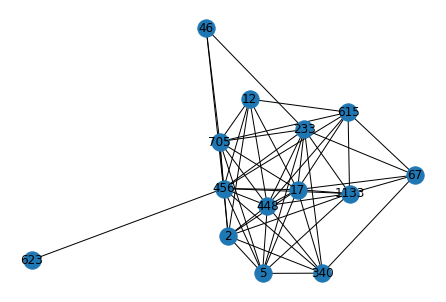

<Figure size 1224x216 with 0 Axes>

,Id,Score,Title
0,456,0.495,Development of a distributed recommender system using the Hadoop Framework
1,1133,0.319,Extraction de termes centrée autour de l'expert
2,705,0.275,Une approche fondée sur la corrélation entre prédicats pour le traitement des réponses pléthoriques
3,448,0.231,Clustering hiérarchique non paramétrique de données fonctionnelles
4,615,0.209,Apprentissage de patrons lexico-syntaxiques à partir de textes
5,12,0.165,Catégorisation d'articles scientifiques basée sur les relations sémantiques des mots-clés
6,340,0.165,Intégration de plusieurs formes de représentations spatiales dans un modèle de simulation
7,46,0.143,NFB: protocole de Notarisation des Documents dans la Blockchain
8,623,0.143,CARTOCEL : Un outil de cartographie des connaissances guidée par la machine cellulaire CASI


In [0]:
# Recommanding articles ...
_article_already_read = [2,5,67,17,233]
_nb_recommendation = 10
_plot_subgraph = True
sorted_node , ranking_index = sc.recommend_articles(article_already_read= _article_already_read ,
                                                    nb_recommendations=_nb_recommendation,
                                                    plot_subgraph = _plot_subgraph)

# Printing results  in dataFrame ...  
result_df = pd.DataFrame(columns=["Id","Score","Title"])
i = 0 
for n in sorted_node:
  result_df.loc[i, "Id"] = n
  result_df.loc[i, "Score"] = ranking_index[n]
  result_df.loc[i, "Title"] = str(sc.get_graph().nodes[n]["title"]).strip()
  #print("id: ",n," | ", ranking_index[n], "| Title:",G.nodes[n]["title"])
  i+=1

pd.set_option("display.max_colwidth",800)
result_df